<a href="https://colab.research.google.com/github/l1kemood/Demo/blob/main/mnist_%E6%B3%A8%E6%84%8F%E5%8A%9B%E6%A8%A1%E5%9D%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
from torch import nn,optim
from torch.autograd import Variable
from torchvision import datasets,transforms # Corrected the module name from 'torchvison' to 'torchvision'
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt


In [8]:
train_dataset=datasets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

In [9]:
#Batch size
batch_size=64
#Loaded in the training set
train_loader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
#Loaded in the testing set
test_loader=DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

In [10]:
for i,data in enumerate(train_loader):
  inputs,labels=data
  print(inputs.shape)
  print(labels.shape)
  break

torch.Size([64, 1, 28, 28])
torch.Size([64])


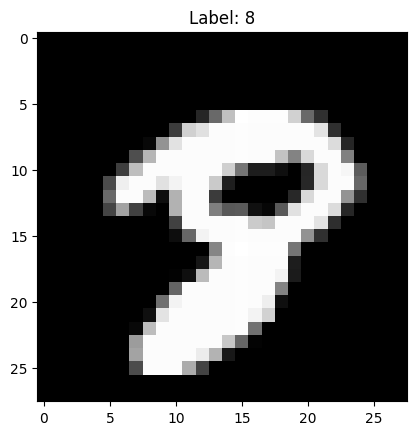

In [5]:
for i, data in enumerate(train_loader):
  inputs, labels = data
  break

plt.imshow(inputs[0].squeeze(), cmap='gray')
plt.title(f"Label: {labels[0]}")
plt.show()

In [6]:
#Define network structure
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(1,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
    self.conv2 = nn.Sequential(nn.Conv2d(32,64,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
    self.fc1 = nn.Sequential(nn.Linear(64*7*7,500),nn.Dropout(p=0.5),nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(500,10),nn.Softmax(dim=1))

  def forward(self,x):
    # [64, 1, 28, 28]
    x = self.conv1(x)
    x = self.conv2(x)
    #(64,64,7,7)
    x = x.view(x.size()[0],-1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [11]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = self.conv1(x)
        attn = self.sigmoid(attn)
        return x * attn  # 将注意力权重应用于输入特征

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,32,5,1,2),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, 5, 1, 2), nn.ReLU(), nn.MaxPool2d(2, 2))
        self.attention = SpatialAttention(64)  # 添加注意力模块
        self.fc1 = nn.Sequential(nn.Linear(64 * 7 * 7, 500), nn.Dropout(p=0.5), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(500,10),nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention(x)  # 应用注意力模块
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [14]:
LR = 0.0003
#Define the model
model = Net()
#Define cost function
mse_loss = nn.CrossEntropyLoss()
#Define optimizer,Set L2 regularization
optimizer = optim.Adam(model.parameters(),LR)

In [15]:
def train():
  #Training state
  model.train()
  for i,data in enumerate(train_loader):
    #Get a batch of data and labels
    inputs,labels = data
    #Obtain model prediction results (64,10)
    out = model(inputs)
    #Cross entropy cost function out(batch,C),labels (batch)
    loss = mse_loss(out,labels)
    #Gradient clearing
    optimizer.zero_grad()
    #Calculated gradient
    loss.backward()
    #Update parameters
    optimizer.step()

def test():
  #Testing state
  model.eval()
  correct = 0
  for i,data in enumerate(test_loader):
    #Get a batch of data and labels
    inputs,labels = data
    #The model prediction results were obtained(64,10)
    out = model(inputs)
    #Get the maximum value and the location of the maximum value
    _,predicted = torch.max(out,1)
    #Predict the correct amount
    correct += (predicted == labels).sum()
  print("Test acc:{0}".format(correct.item()/len(test_dataset)))

  correct = 0
  for i,data in enumerate(train_loader):
    #Get a batch of data and labels
    inputs,labels = data
    #The model prediction results were obtained(64,10)
    out = model(inputs)
    #Get the maximum value and the location of the maximum value
    _,predicted = torch.max(out,1)
    #Predict the correct amount
    correct += (predicted == labels).sum()
  print("Train acc:{0}".format(correct.item()/len(train_dataset)))




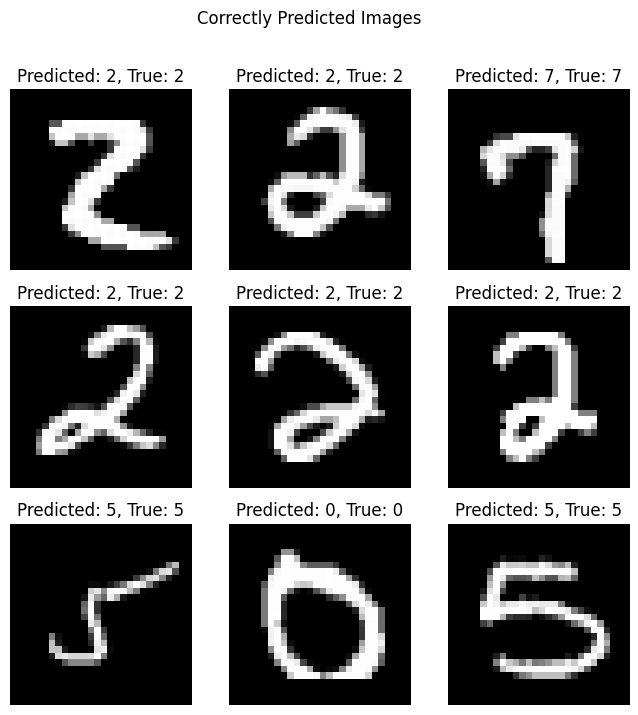

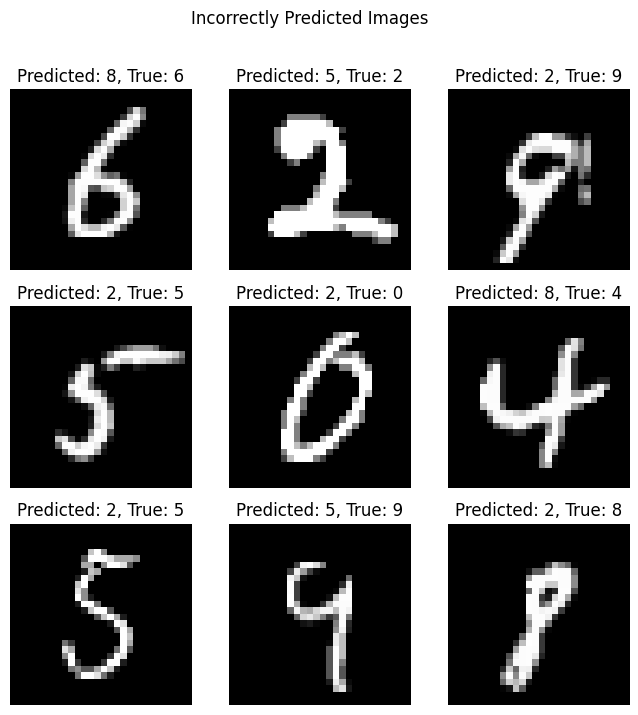

In [ ]:
# 获取预测结果和对应的图像数据
predictions = []
true_labels = []
all_images = []
for i, data in enumerate(train_loader):
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    predictions.extend(predicted.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())
    all_images.extend(inputs.cpu().numpy())

# 筛选预测结果
correct_indices = np.where(np.array(predictions) == np.array(true_labels))[0]
incorrect_indices = np.where(np.array(predictions) != np.array(true_labels))[0]

# 可视化预测结果
# 准确预测的图像
plt.figure(figsize=(8, 8))
for i, index in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[index].squeeze(), cmap='gray') # 使用 all_images[index] 获取图像
    plt.title(f"Predicted: {predictions[index]}, True: {true_labels[index]}")
    plt.axis('off')
plt.suptitle("Correctly Predicted Images")
plt.show()

# 预测失败的图像
plt.figure(figsize=(8, 8))
for i, index in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(all_images[index].squeeze(), cmap='gray') # 使用 all_images[index] 获取图像
    plt.title(f"Predicted: {predictions[index]}, True: {true_labels[index]}")
    plt.axis('off')
plt.suptitle("Incorrectly Predicted Images")
plt.show()

In [ ]:
#不要运行，不要运行，不要运行
#正常使用CNN
#使用dorpout,测试状态不适用dropput
#使用adam优化器代替sgd优化器
#在优化器中添加L2正则化代码
for epoch in range(20):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9766
Train acc:0.9749666666666666
epoch: 1
Test acc:0.9831
Train acc:0.98385
epoch: 2
Test acc:0.9803
Train acc:0.97955
epoch: 3
Test acc:0.9817
Train acc:0.9836
epoch: 4
Test acc:0.99
Train acc:0.9907166666666667
epoch: 5
Test acc:0.9894
Train acc:0.9901
epoch: 6
Test acc:0.989
Train acc:0.9906166666666667
epoch: 7
Test acc:0.99
Train acc:0.9907666666666667
epoch: 8
Test acc:0.9866
Train acc:0.98905
epoch: 9
Test acc:0.9844
Train acc:0.9866666666666667
epoch: 10
Test acc:0.9879
Train acc:0.988
epoch: 11
Test acc:0.9888
Train acc:0.9894
epoch: 12
Test acc:0.9913
Train acc:0.9930333333333333
epoch: 13
Test acc:0.9882
Train acc:0.9908333333333333
epoch: 14
Test acc:0.9917
Train acc:0.99265
epoch: 15
Test acc:0.9871
Train acc:0.9899666666666667
epoch: 16
Test acc:0.9901
Train acc:0.9917
epoch: 17
Test acc:0.9877
Train acc:0.9887
epoch: 18
Test acc:0.9867
Train acc:0.9899666666666667
epoch: 19
Test acc:0.9901
Train acc:0.9913833333333333


In [ ]:
#简化模型
#Reduce the number of layers of the network or the number of neurons per layer
#将全连接层的神经元数量从 1000 减少到 500

for epoch in range(10):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9761
Train acc:0.97145
epoch: 1
Test acc:0.9858
Train acc:0.9834166666666667
epoch: 2
Test acc:0.9881
Train acc:0.9882166666666666
epoch: 3
Test acc:0.9875
Train acc:0.9877
epoch: 4
Test acc:0.9887
Train acc:0.98945
epoch: 5
Test acc:0.9882
Train acc:0.9892333333333333
epoch: 6
Test acc:0.9907
Train acc:0.99235
epoch: 7
Test acc:0.9898
Train acc:0.9914333333333334
epoch: 8
Test acc:0.9926
Train acc:0.993
epoch: 9
Test acc:0.9889
Train acc:0.9913


In [ ]:
#调整学习率从0.001缩小为0.0003
for epoch in range(10):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9712
Train acc:0.96995
epoch: 1
Test acc:0.9802
Train acc:0.97815
epoch: 2
Test acc:0.9828
Train acc:0.9832166666666666
epoch: 3
Test acc:0.9843
Train acc:0.9857
epoch: 4
Test acc:0.9877
Train acc:0.9903833333333333
epoch: 5
Test acc:0.9884
Train acc:0.99125
epoch: 6
Test acc:0.9904
Train acc:0.9928833333333333
epoch: 7
Test acc:0.9887
Train acc:0.9923333333333333
epoch: 8
Test acc:0.9904
Train acc:0.9933666666666666
epoch: 9
Test acc:0.9909
Train acc:0.99325


In [16]:
#添加注意力模块
for epoch in range(10):
  print('epoch:',epoch)
  train()
  test()

epoch: 0
Test acc:0.9686
Train acc:0.9658666666666667
epoch: 1
Test acc:0.9776
Train acc:0.9762666666666666
epoch: 2
Test acc:0.9841
Train acc:0.9845166666666667
epoch: 3
Test acc:0.9863
Train acc:0.9867333333333334
epoch: 4
Test acc:0.9852
Train acc:0.9867
epoch: 5
Test acc:0.9893
Train acc:0.9900833333333333
epoch: 6
Test acc:0.9894
Train acc:0.9913666666666666
epoch: 7
Test acc:0.9904
Train acc:0.9920166666666667
epoch: 8
Test acc:0.99
Train acc:0.9924166666666666
epoch: 9
Test acc:0.9913
Train acc:0.9940666666666667
